In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models ,layers , utils 
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report , accuracy_score


### preparing the x data

In [2]:
def preparing_data(path):
    img_list=[]
    path_list=[]
    for img_path in os.listdir(path):
         
        img = cv2.imread(path + '/' + img_path)
        if img is not None :
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize( img , (127,127))
            img = img/127
    
            img_list.append(img)
            path_list.append(img_path)
    return img_list,path_list

In [3]:
train_normal, train_normal_path =preparing_data('chest_xray/chest_xray/train/NORMAL')

In [4]:
train_pneumonia , train_pneumonia_path= preparing_data('chest_xray/chest_xray/train/PNEUMONIA')

In [5]:
test_pneumonia , test_pneumonia_path= preparing_data('chest_xray/chest_xray/test/PNEUMONIA')

In [6]:
test_normal, test_normal_path =preparing_data('chest_xray/chest_xray/test/NORMAL')

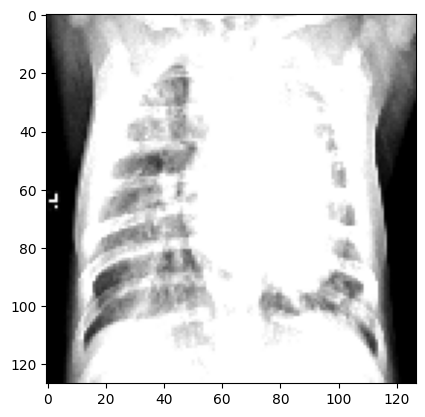

In [73]:
###example from pneuomonial x_ray
plt.imshow(test_pneumonia[0],'gray')

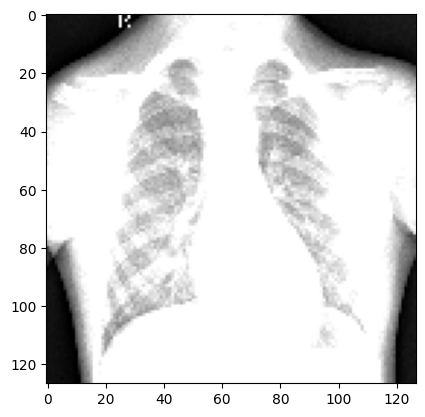

In [74]:
### example from normal x_ray
plt.imshow(test_normal[6])

#### fix imbalancing

In [8]:
##### to make the number of pneumonia x_rays is equal to number of normal x_rays


train_pneumonia = train_pneumonia[:len(train_normal)]

In [9]:
print(len(train_pneumonia))
print(len(train_normal))

1341
1341


In [10]:
print('the lenght of train_normal is equal to:' , len(train_normal))
print('the lenght of train_pneumonia is equal to:' , len(train_pneumonia))
print('the lenght of test_normal is equal to:' , len(test_normal))
print('the lenght of test_pneumonia is equal to:' , len(test_pneumonia))

the lenght of train_normal is equal to: 1341
the lenght of train_pneumonia is equal to: 1341
the lenght of test_normal is equal to: 234
the lenght of test_pneumonia is equal to: 390


In [11]:
x_train = train_pneumonia + train_normal
x_test = test_pneumonia + test_normal

In [12]:
len(x_train)

2682

In [13]:
len(x_test)

624

In [14]:
x_test[0].shape

(127, 127, 3)

### prepare the y data

In [15]:
y_train = [0] * len(train_pneumonia) + [1] * len(train_normal)
y_test =  [0] * len(test_pneumonia) + [1] * len(test_normal)

In [16]:
print('number of zeros and ones in y_train is', Counter(y_train))
print('\nnumber of zeros and ones in y_test is', Counter(y_test))
print('\nwhere zeros are for pnoeumonial and ones are for normal')

number of zeros and ones in y_train is Counter({0: 1341, 1: 1341})

number of zeros and ones in y_test is Counter({0: 390, 1: 234})

where zeros are for pnoeumonial and ones are for normal


In [17]:
y_train = utils.to_categorical(y_train,num_classes=2)
y_test = utils.to_categorical(y_test,num_classes=2)

In [18]:
rows_as_tuples = [tuple(row) for row in y_test]

# Use Counter to count occurrences of each unique row
row_counts = Counter(rows_as_tuples)

# Print the counts
for row, count in row_counts.items():
    print(f"{row}: {count}")

(1.0, 0.0): 390
(0.0, 1.0): 234


In [19]:
y_train=np.array(y_train)
y_test = np.array(y_test)
x_train = np.array(x_train)
x_test = np.array(x_test)

### data augmentation to reduce overfitting

In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2682, 127, 127, 3)
(2682, 2)
(624, 127, 127, 3)
(624, 2)


In [22]:
from tensorflow.keras import backend as K
K.clear_session()


In [23]:
model=models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', strides=1, activation='relu', input_shape=(x_train[0].shape), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(Dropout(0.5))
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same' , strides=1 , activation= 'relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(12,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 127, 127, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,936,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,958,598 (15.10 MB)

 Trainable params: 3,958,406 (15.10 MB)

 Non-trainable params: 192 (768.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
model.fit(x_train,y_train , epochs =8, validation_data=(x_test,y_test),callbacks=[early_stopping, reduce_lr])

Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 489ms/step - accuracy: 0.5786 - loss: 2.1155 - val_accuracy: 0.3750 - val_loss: 29.4946 - learning_rate: 0.0010
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 482ms/step - accuracy: 0.8607 - loss: 0.4453 - val_accuracy: 0.4904 - val_loss: 8.2914 - learning_rate: 0.0010
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.8884 - loss: 0.3134 - val_accuracy: 0.3894 - val_loss: 17.0395 - learning_rate: 0.0010
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 481ms/step - accuracy: 0.9402 - loss: 0.2379 - val_accuracy: 0.7003 - val_loss: 1.4983 - learning_rate: 0.0010
Epoch 5/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 480ms/step - accuracy: 0.9444 - loss: 0.1837 - val_accuracy: 0.6346 - val_loss: 2.3822 - learning_rate: 0.0010
Epoch 6/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 473ms/step - accuracy: 0.9453 - loss: 0.1880 - val_accuracy: 0.8478 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 7/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 472ms/step - accuracy: 0.9538 - loss: 0.1600 

In [36]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
model.fit(x_train,y_train , epochs =2, validation_data=(x_test,y_test),callbacks=[early_stopping, reduce_lr])

Epoch 1/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 491ms/step - accuracy: 0.9380 - loss: 0.2400 - val_accuracy: 0.6250 - val_loss: 13.4142 - learning_rate: 0.0010
Epoch 2/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 485ms/step - accuracy: 0.9492 - loss: 0.2374 - val_accuracy: 0.8766 - val_loss: 0.5563 - learning_rate: 0.0010


In [25]:
model.save('chest x_ray model.h5')
print('saved')

saved


In [26]:
from tensorflow.keras.models import load_model

model = load_model('chest x_ray model.h5')

#### evaluation

In [37]:
val_normal, val_normal_path =preparing_data('chest_xray/chest_xray/val/NORMAL')
val_pneumonia , val_pneumonia_path= preparing_data('chest_xray/chest_xray/val/PNEUMONIA')

In [38]:
x_val = val_pneumonia +val_normal


In [39]:
y_val = [0] * len(val_pneumonia) + [1] * len(val_normal)

In [40]:
y_val = np.array(y_val)
x_val = np.array(x_val)

In [56]:
y_pred = model.predict(x_val)
y_val_pred = np.argmax(y_pred, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [58]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
y_val_pred

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [63]:
y_val_pred = model.predict(x_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test = np.argmax(y_test, axis=1)



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [61]:
accuracy_score(y_test, y_val_pred_classes)


0.8766025641025641

In [50]:
precision_score(y_test, y_val_pred_classes, average='weighted')


0.8795127799792786

In [52]:
recall_score(y_test, y_val_pred_classes, average='weighted')


0.8766025641025641

In [53]:
f1_score(y_test, y_val_pred_classes, average='weighted')

0.8773905230303604

In [47]:
import seaborn as sns


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


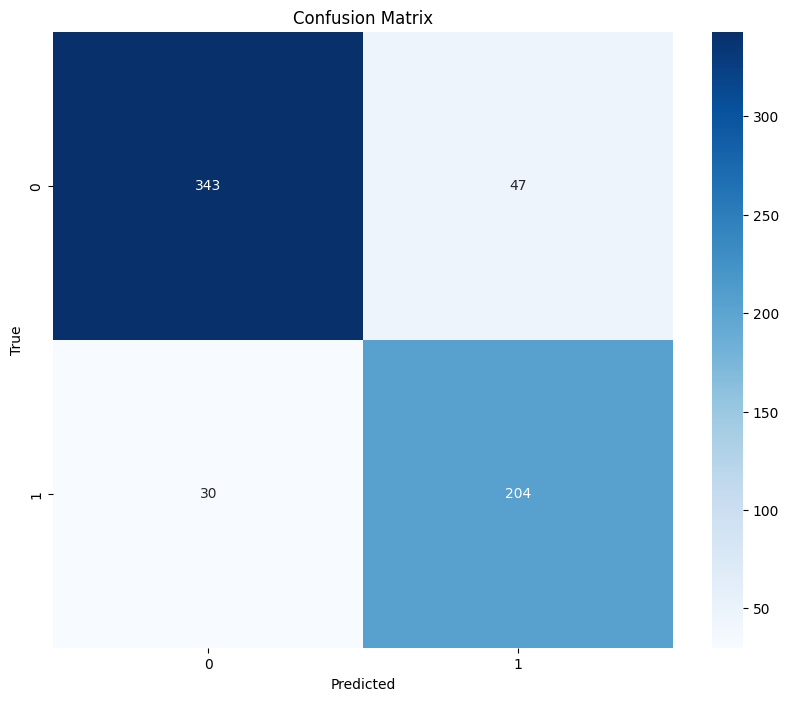

In [48]:
y_val_pred = model.predict(x_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

cm = confusion_matrix(y_test, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()